# Tutorial for EBPCA.
The EBPCA toolbox currently contains four modules for a complete EBPCA analysis--data preprocessing, pca analysis, empirical Bayes denoiser and amp iteratiave correction. The intention here is to provide a user with a working knowledge of the EBPCA method and this package.

## Step 1: Model specification
Consider your observational matrix $Y\in\mathbb{R}^{n\times p}$ has a low rank signal-plus-noise model, which we assue the noise matrix $\mathbf{W}$ has entries $w_{ij} \overset{\textrm{i.i.d}}{=} \mathcal{N}(0,\tau^2/n)$. Before we proceed, we should note the following two properties of the data:

1. Determine the number of identifiable PCs.
2. Observe if the prior has clear non-Gaussian structure.

Suppose we have the following synthetic observation $Y$:


In [8]:
import numpy as np
from tutorial import normalize_pc, get_MSE
n = 500
p = 1000

# signal part
V = np.array([[1,3,2],[1,-2,0],[-1,2,1],[-1,-1,-1]])
Qv, _ = np.linalg.qr(V)
Vstar = np.repeat(Qv, int(p/4), axis = 0)
Ustar = np.random.multivariate_normal(mean = np.array([0,0,0]), cov = np.array([[1,0,0],[0,1,0],[0,0,1]]), size = int(n))
Ustar = normalize_pc(Ustar); Vstar = normalize_pc(Vstar)
signals = [2.5, 1.8, 0.2]

# noise part
tau = 0.9
W = np.random.normal(size = n * p).reshape((n,p)) / np.sqrt(n) * tau

# observational matrix
Y = Ustar * signals @ Vstar.T/n + W

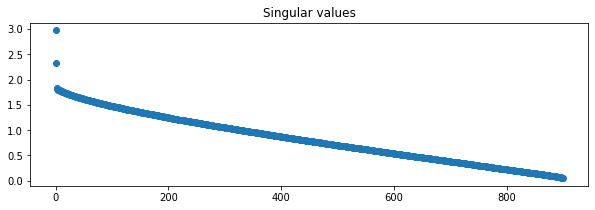

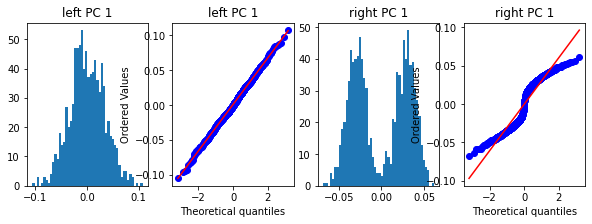

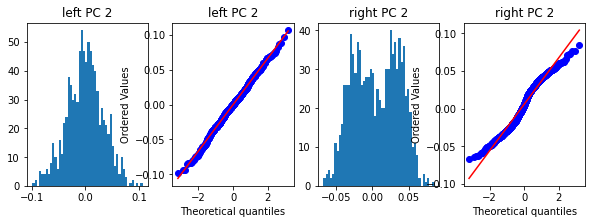

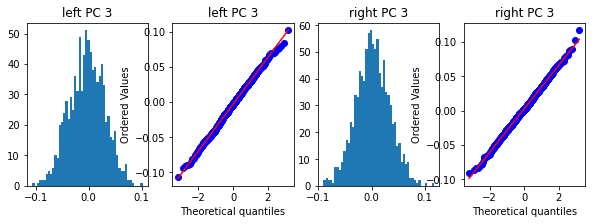

In [4]:
from ebpca.preprocessing import plot_pc
plot_pc(Y,nPCs=3, to_show=True, to_save=False)

Even though our data have seemly 3 singal components, only the top two stand out. The last one's singal strengh is too weak therefore covered by the noise. Accordingly, the left and the right PC of the last component is approximately Gaussian.

We also note there are distinct patterns for the left PCs, and the distribution of the right PCs are approximatly Gaussian. Our theory shows there is no additional gain by denoising the PC with Gaussian distribution from pure SVD.

Therefore, we set the `rank` of algorithm to be  2, and we will only denoise the left PCs.

## Step 2: PCA pack

We will normalize the data such that the noise level satisfy our model assumption, and in the mean time calculate the relevent parameters for EBPCA from observational matrix $Y_\textrm{obs}$. Some readers might wonder if the noise term satisfy our assumption. One way to do this is through checking whether the singular value distribution of the noise matrix satisfy MP law. See [MP law](https://en.wikipedia.org/wiki/Marchenko–Pastur_distribution).

estimated tau=0.8968638762431457
s should be at least 0.8409 to satisfy the super critical condition.
singval should be at least 2.4142 to satisfy the super critical condition.
Estimation of s is [2.803619   2.06777779].


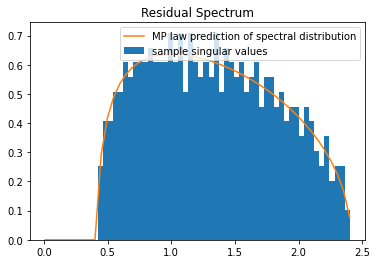

In [9]:
rank = 2 # By observing the data, we set rank to be 2.

# Normalize the observational matrix.
from ebpca.preprocessing import normalize_obs
from ebpca.pca import get_pca, check_residual_spectrum
X = normalize_obs(Y, rank)

# Prepare the PCA pack.
pcapack = get_pca(X, rank)

# Spectrum of the residual matrix (noise).
check_residual_spectrum(pcapack, to_show = True)

For real world data, most likely, the noise term doesn't exactly follow our assumption, and thus the MP can give such an accurate characterization of the residual matrix's spectrum. *But we can still use it because??? I don't know.*

## Step 3: EBAMP 
### Empirical Bayes method
User should first specfy the denoisers for the left and the right PCs. By default, they would be the non-parametric empirical Bayes estimator `NonparEB`. If users believes the prior can be parametrized by a parametric distribution family, they can implement their own estimator. 

For our current NonparEB, users can choose from two optimzers to solve the MLE problem--"Mosek" or "EM". We strongly recommend users to use *Mosek* as it runs much faster. If the users are not able to get the licence for *Mosek*, they can use *EM* by default.

Users can also set `nsupp_ratio` from 0 to 1, to control the number of support points we sample from observations. This will linearly improve the computational time. However, this may lose information on the scarce outlying samples.

### AMP
Users should set the number of amp iterations to run. AMP converges with in several steps, and later iterations might amplify numerical errors, we highly recommend `iters` to be less than 5. If users find the left PCs are approximately Gaussian, he is optional to turn that off by setting `mutev = True`.

In [4]:
# This is a practical application of ebpca
from ebpca.empbayes import NonparEB

from ebpca.amp import ebamp_gaussian

udenoiser = NonparEB(optimizer = "Mosek", ftol = 1e-3, nsupp_ratio = 1)

U, _ = ebamp_gaussian(pcapack, iters=3, udenoiser=udenoiser, figprefix="tut", mutev = True)

# check for alignment along iterations
from tutorial import get_alignment
res = []
iters = U.shape[-1]
for i in range(iters):
    ans = get_alignment(U[:,:,i], Ustar)
    res.append(ans)
print("Algnment along iterations:")
print(res)

iteration 0
[1.81875140s] estimate_prior
[0.00069849s] denoise
[0.00888044s] ddenoise
iteration 1
[1.49889997s] estimate_prior
[0.00068959s] denoise
[0.00875763s] ddenoise
iteration 2
[1.51365862s] estimate_prior
[0.00087224s] denoise
[0.00830916s] ddenoise
[4.86591169s] ebamp_gaussian(iters=3)
Algnment along iterations:
[0.8257267489906722, 0.8889005296767448, 0.8938076748383383, 0.894434703720318]


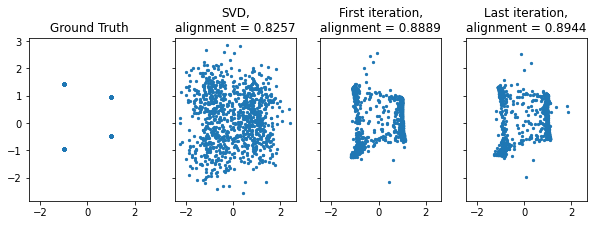

In [5]:
# Ustar is identified up to a flip sign.
from tutorial import redirect_pc
Ustar = redirect_pc(Ustar[:,:rank], pcapack.U)

from tutorial import compare_with_truth
compare_with_truth(Ustar, U, to_show=True)

We use the following example to show ebpca is denoising at the correct level of noise by plotting out the convolved density of the true prior with guassian with our estimated SNR $(M,\Sigma)$. We observe the distribution of the marginal is in correspondence with the density.

iteration 0
[2.92551362s] estimate_prior


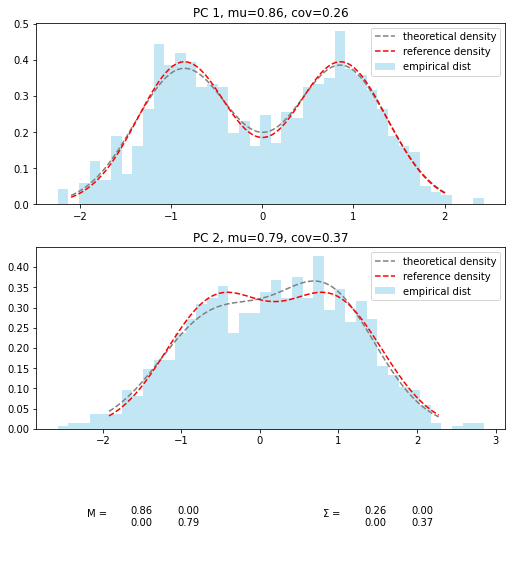

[0.00075870s] denoise
[0.00810350s] ddenoise
iteration 1
[2.96853057s] estimate_prior


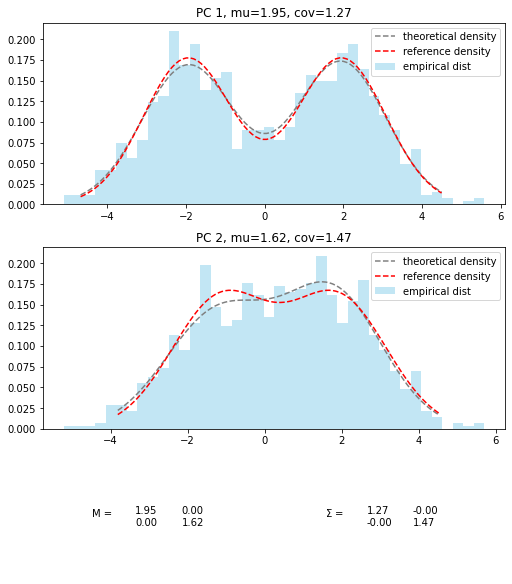

[0.00083983s] denoise
[0.00780701s] ddenoise
iteration 2
[3.02480940s] estimate_prior


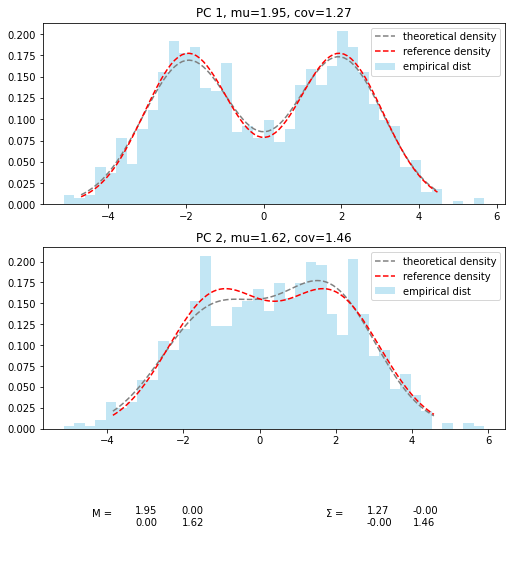

[0.00080627s] denoise
[0.00782719s] ddenoise
[11.39988110s] ebamp_gaussian(iters=3)


In [7]:





truePriorLoc = Ustar
truePriorWeight = np.full((len(truePriorLoc),), 1/len(truePriorLoc)) 

from ebpca.empbayes import NonparEBChecker 
from ebpca.amp import ebamp_gaussian
from ebpca.empbayes import NonparEB

udenoiser = NonparEBChecker(truePriorLoc, truePriorWeight, optimizer ="EM", em_iter = 1000,to_show = True)
U, _ = ebamp_gaussian(pcapack, iters=3, udenoiser=udenoiser, figprefix="tut", mutev = True)
